# Importation des bibliothéques

In [86]:
import os
os.environ["SPARK_HOME"] = "/home/anyes/spark"
os.environ["JAVA_HOME"] = "/usr"

In [87]:
import pandas as pd
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql.functions import col
from pyspark.sql import functions as F

from igraph import Graph
from pyspark.sql.window import Window
from pyspark.sql.functions import col

from functools import reduce
from pyspark.sql.functions import collect_set, min as min_, expr,array_min,max
from pyspark.sql.functions import lit

from graphframes import GraphFrame


# Lancer Spark

In [88]:
# initialise environment variables for spark
findspark.init()

# Start spark session
# --------------------------
def start_spark():
  #fixer la valeur au lieu de * 
  local = "local[*]"
  appName = "PLDAC"

  gf = "graphframes:graphframes:0.8.3-spark3.5-s_2.12"

  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.jars.packages", gf)

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # Adjust the query execution environment to the size of the cluster (4 cores)
  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session started, its id is ", sc.applicationId)
  return spark
spark = start_spark()

session started, its id is  local-1710842935118


# Calcul en parallèle des composantes connectées pour tous les fichiers de partition

In [89]:
def calculate_partition_components(partition_folder):

    def components(partition_file) :
        df = pd.read_parquet(partition_file)
        g = Graph.TupleList(df[['seqID1', 'seqID2']].itertuples(index=False), directed=False)
        connected_components = g.connected_components()
        node_ids=[]
        for component in connected_components:
            node_ids.append([g.vs[node_index]['name'] for node_index in component])
        #on trie en fonction de la taille 
        composantes_triees = sorted(node_ids, key=len, reverse=True)
        # Créer une liste de lignes pour chaque composante
        rows = []
        for i, component in enumerate(composantes_triees):
            for seqid in component:
                rows.append((seqid , i))
        return rows

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    #data = [(file,) for file in os.listdir(partition_folder)]
    data = [(i,) for i, file in enumerate(os.listdir(partition_folder))]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(len(data))

    # Enregistrer la fonction UDF
    schema_components = StructType([
        StructField("seqID", StringType(), nullable=False),
        StructField("component_id", IntegerType(), nullable=False)
    ])

    components_udf = F.udf(components, ArrayType(schema_components))

    #df_with_components = df.withColumn("components", components_udf(F.concat(F.lit(partition_folder+"/"), df["file"])))
    df_with_components = df.withColumn(
        "components",
        components_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            )
        )
    )
    
    return df_with_components

In [90]:
partition_folder = "./local/partitionned_data/BDLE_10K"
df_with_components = calculate_partition_components(partition_folder)
df_with_components.show()

+----+--------------------+
|file|          components|
+----+--------------------+
|   0|[{102674247:5, 0}...|
|   1|[{25029626:0, 0},...|
|   2|[{41179534:1, 0},...|
|   3|[{116095523:2, 0}...|
|   4|[{125640338:1, 0}...|
|   5|[{124175704:0, 0}...|
|   6|[{41164712:3, 0},...|
|   7|[{138282057:0, 0}...|
|   8|[{41137266:3, 0},...|
|   9|[{17696323:4, 0},...|
|  10|[{103533986:1, 0}...|
|  11|[{142280051:4, 0}...|
|  12|[{13373965:3, 0},...|
|  13|[{109694874:5, 0}...|
|  14|[{41193498:4, 0},...|
|  15|[{107642134:1, 0}...|
|  16|[{EukProt-v2_CAMP...|
|  17|[{25029626:2, 0},...|
|  18|[{116143369:3, 0}...|
|  19|[{3130679:0, 0}, ...|
+----+--------------------+



# Calcul des composantes connexes du graph complet

In [91]:
def components_2(edges):
    # Créer un graphe à partir des arêtes
    g = Graph.TupleList(edges, directed=False)
    
    connected_components = g.connected_components()
    node_ids=[]
    for component in connected_components:
        node_ids.append([g.vs[node_index]['name'] for node_index in component])
    #on trie en fonction de la taille 
    composantes_triees = sorted(node_ids, key=len, reverse=True)
    # Créer une liste de lignes pour chaque composante
    rows = []
    for i, component in enumerate(composantes_triees):
        for seqid in component:
            rows.append(Row(partial_component=seqid ,component=i ))
    
    # Créer un DataFrame Spark à partir de la liste de lignes
    result_df = spark.createDataFrame(rows)
    return result_df

In [93]:
def calculate_components(folder_partition ):
    # Claclul des composantes partielles dans chaque partition
    df_with_components = calculate_partition_components(folder_partition)
    df_exploded = df_with_components.select('file',  explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))
    
    # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")

    # new_df = df_split.select(
    #             'seqID',
    #             concat(col('file'), lit(':'), col('component_id')).alias('new_component_id')
    #         )
    
    #cration d'un graph ou chaque noeud est le numero d'une composante (new_graph)

    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))

    # components_per_node = new_df \
    #     .groupby("seqID") \
    #     .agg(collect_set("new_component_id").alias("components")) \
    #     .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()
  
    
    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")

    #calcul des composantes sur le nouveau graph
    edges =new_graph.select('src', 'dst').collect() #c'est couteux --> on doit faire un repartition de 1
    composantes_df = components_2(edges)

    composantes_df_exploded = composantes_df \
            .groupby("component") \
            .agg(collect_set("partial_component").alias("partial_components")) \
            .withColumn("min_partial_component", array_min("partial_components")) \
            .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")
    
    #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    file_path = f"./local/Components/BDLE_10K"
    # changer le degre de paraléllisme
    #definir le degre de paraléllisme pour les opérations groupby join ...
    result.repartition(1).write.mode("overwrite").parquet(file_path)
    
    return result


## Calcul des composantes avec la nouvelle méthode

In [94]:
partition_folder = "./local/partitionned_data/BDLE_10K"
result = calculate_components(partition_folder)
result.show()

+-----------+----------------+
|      seqID|new_component_id|
+-----------+----------------+
| 10034756:1|             716|
|100367569:3|            1232|
|100243206:2|            1344|
|100366948:0|             328|
|100250530:5|            2032|
|100368262:0|            2088|
|100367971:5|            1497|
|100368246:4|            2644|
|100218437:3|            2885|
|100073848:2|            1971|
|100232688:1|            4563|
|100368018:2|            4876|
| 10026196:2|             716|
|100367776:2|            1483|
|100368290:5|            2601|
|100102421:5|            6406|
|100265858:2|            4494|
|100149617:5|            6825|
|100171640:4|           10008|
|100368089:4|             999|
+-----------+----------------+
only showing top 20 rows



## Calcul des composantes avec grapheFrame

In [95]:
def calculate_components_with_graphframe(folder_partition) :
    spark.sparkContext.setCheckpointDir('./content/checkpoints')
    #Création du data frame spark
    df = spark.read.format("parquet").option("compression", "snappy").load(folder_partition)

    vertices = df.selectExpr("seqID1 as id").union(df.selectExpr("seqID2 as id")).distinct()
    edges = df.select("seqID1", "seqID2", "sim").withColumnRenamed("seqID1", "src").withColumnRenamed("seqID2", "dst")

    graph = GraphFrame(vertices, edges)
    connected_components = graph.connectedComponents()

    file_path = f"./local/Components_with_graphframe/BDLE_10K"
    result.repartition(1).write.mode("overwrite").parquet(file_path)

    return connected_components

In [39]:
folder_partition = "./local/partitionned_data/BDLE_10K"
df = calculate_components_with_graphframe(folder_partition)
df.show()

+-----------+---------+
|         id|component|
+-----------+---------+
|100058801:0|        0|
|100073848:2|        1|
|100102421:5|        2|
|100149617:5|        3|
|100171640:4|        4|
|100218437:3|        5|
|100232688:1|        6|
|100243206:2|        7|
|100250530:5|        8|
| 10026196:2|        9|
|100265858:2|       10|
| 10034756:1|        9|
|100366948:0|       12|
|100367569:3|       13|
|100367776:2|       14|
|100367971:5|       15|
|100368018:2|       16|
|100368089:4|       17|
|100368246:4|       18|
|100368262:0|       19|
+-----------+---------+
only showing top 20 rows



# Comparaison de temps d'execution entre graphframe et la nouvelle méthode

## Nouvelle méthode

In [96]:
import time

folder_partition = "./local/partitionned_data/BDLE_10K"

start_time = time.time()
result_df = calculate_components(folder_partition)
end_time = time.time()
print("Temps d'execution avec la nouvelle methode : ", end_time - start_time)

Temps d'execution avec la nouvelle methode :  6.706066846847534


## Avec graphframe

In [97]:
start_time = time.time()
result_df_with_graphframe = calculate_components_with_graphframe(folder_partition)
end_time = time.time()
print("Temps d'execution avec graphframe : ", end_time - start_time)

/home/anyes/.local/lib/python3.8/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/home/anyes/.local/lib/python3.8/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Temps d'execution avec graphframe :  55.30984425544739


# Calcul du nombre de composantes

In [99]:
grouped_df = result_df.groupBy('new_component_id').agg(count('*').alias('count'))
nb_components = grouped_df.count()
print(f"le nombre de composantes est {nb_components}")

le nombre de composantes est 4300


In [100]:
grouped_df_with_graphframe = result_df_with_graphframe.groupBy('component').agg(count('*').alias('count'))
nb_components_with_graphframe = grouped_df_with_graphframe.count()
print(f"le nombre de composantes est {nb_components_with_graphframe}")

le nombre de composantes est 4300


# TEST de notre methode sur un exemple simple

In [101]:
import matplotlib.pyplot as plt
import networkx as nx

In [117]:
import glob

folder_path = f"./Graph_test/"
# Lire tous les fichiers Parquet dans une liste de DataFrames
dfs = [pd.read_parquet(fichier) for fichier in glob.glob(folder_path + '*.parquet')]

# Concaténer les DataFrames en un seul DataFrame
df = pd.concat(dfs, ignore_index=True)

/home/anyes/.local/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


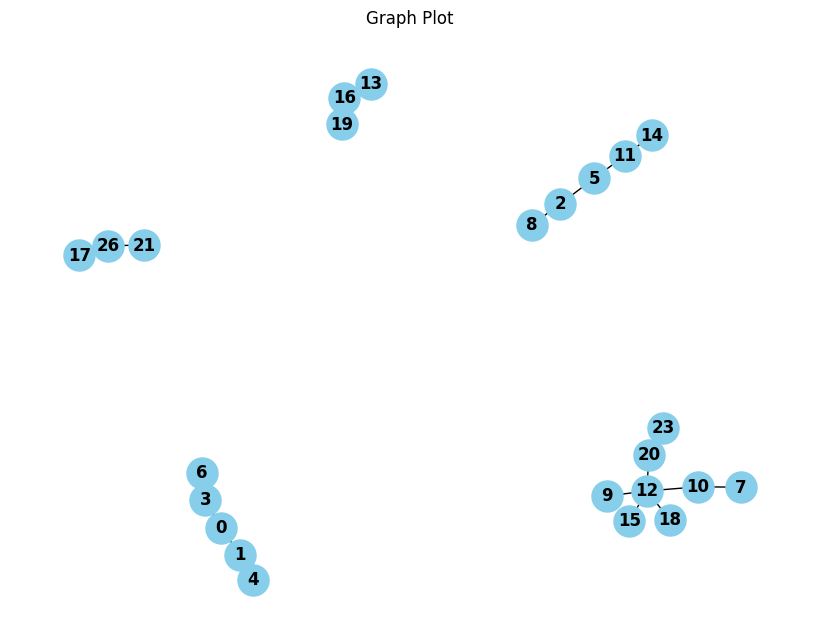

In [109]:
nx_graph = nx.from_pandas_edgelist(df, 'seqID1', 'seqID2')

# Créer un tracé du graphe
plt.figure(figsize=(8, 6))
nx.draw(nx_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title("Graph Plot")
plt.show()

## Partionnement en 3 partitions

In [118]:
# Nombre de partitions
num_partitions = 3

# Ajout d'une nouvelle colonne 'partition' basée sur le modulo de seqID1
df['partition'] = df['seqID1'].apply(lambda x: x % num_partitions)

# Afficher le DataFrame partitionné
df

,seqID1,seqID2,partition
0,3,0,0
1,3,6,0
2,0,1,0
3,1,4,1
4,13,16,1
5,16,19,1
6,15,12,0
7,9,12,0
8,18,12,0
9,12,10,0


In [119]:
partition_freq = df.groupby('partition').size().reset_index(name='count')

# Afficher la fréquence de partition
partition_freq

,partition,count
0,0,9
1,1,4
2,2,6


/home/anyes/.local/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


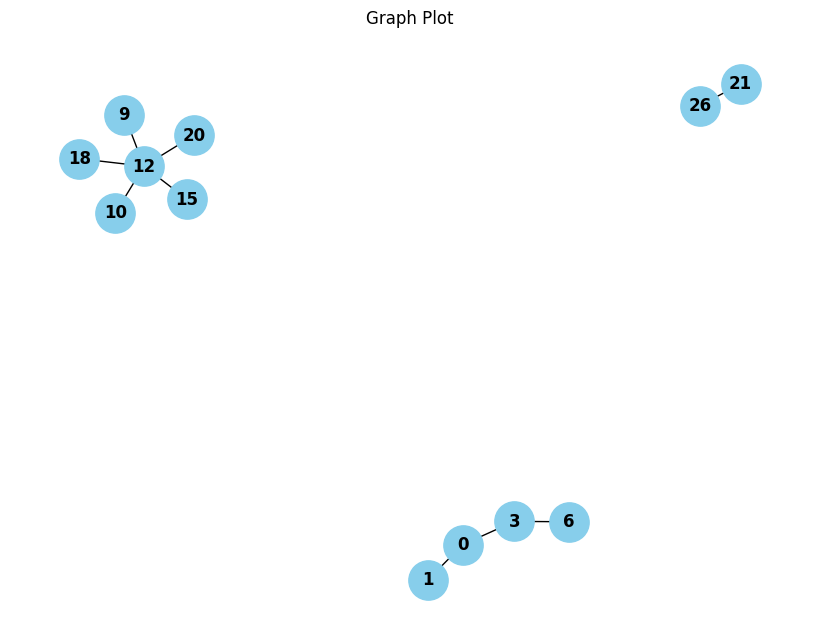

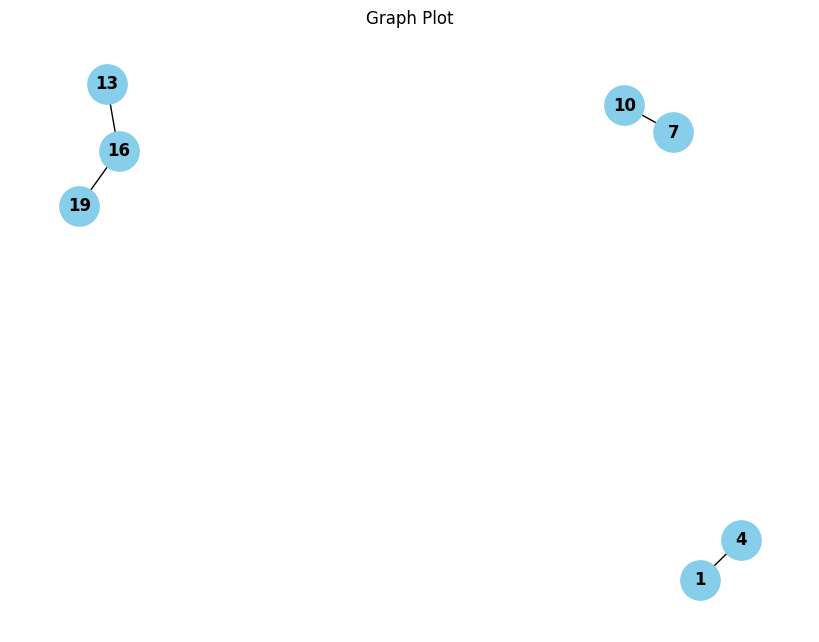

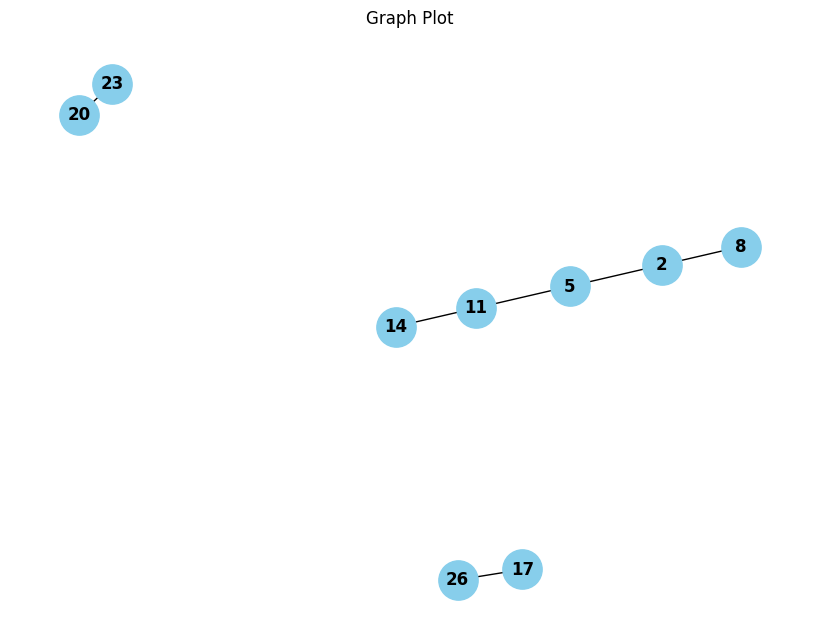

In [120]:
partitions = partition_freq['partition'].unique()
for partition in partitions:
    df_partition = df[df['partition'] == partition]

    nx_graph = nx.from_pandas_edgelist(df_partition, 'seqID1', 'seqID2')
    # Créer un tracé du graphe
    plt.figure(figsize=(8, 6))
    nx.draw(nx_graph, with_labels=True, node_size=800, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
    plt.title("Graph Plot")
    plt.show()


    file_path = f"./partitionned_Graph_test/partition_{partition}.parquet"
    df_partition.to_parquet(file_path, index=False, engine='pyarrow')

In [122]:
partition_folder = "./partitionned_Graph_test"
df_with_components = calculate_components(partition_folder)
df_with_components.show(24)

+-----+----------------+
|seqID|new_component_id|
+-----+----------------+
|   15|               1|
|   12|               1|
|    9|               1|
|   18|               1|
|   10|               1|
|   20|               1|
|    3|               2|
|    0|               2|
|    6|               2|
|    1|               2|
|   21|               3|
|   26|               3|
|   13|               4|
|   16|               4|
|   19|               4|
|    4|               2|
|    7|               1|
|   14|               7|
|   11|               7|
|    5|               7|
|    2|               7|
|    8|               7|
|   23|               1|
|   17|               3|
+-----+----------------+

